In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1
First, I just bring in the data from SPY and VIX. The data is from Feb 11 2007 to Feb 11 2022. It is weekly data that I pulled from Yahoo Finance. I remove the Open, High, Low, Close, and Volume columns, as our strtagey is working with Adj Close data.

In [3]:
dfspy = pd.read_csv('SPY.csv',
                index_col=0,       # Tell Pandas that the first column should be used as an index
                parse_dates=[0]    # Tell Pandas to parse the column at index 0 as dates
                )
dfspy = dfspy.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'])
dfspy = dfspy.rename(columns = {'Adj Close' : 'SPY Adj Close'})
dfspy.head()

,SPY Adj Close
Date,
2007-02-12,108.318275
2007-02-19,107.998672
2007-02-26,103.070694
2007-03-05,104.639046
2007-03-12,102.966667


In [4]:
dfvix = pd.read_csv('^VIX.csv',
                index_col=0,       # Tell Pandas that the first column should be used as an index
                parse_dates=[0]    # Tell Pandas to parse the column at index 0 as dates
                )
dfvix = dfvix.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'])
dfvix = dfvix.rename(columns = {'Adj Close' : 'VIX Adj Close'})
dfvix.head()

,VIX Adj Close
Date,
2007-02-12,10.020000
2007-02-19,10.580000
2007-02-26,18.610001
2007-03-05,14.090000
2007-03-12,16.790001


### Step 2
I merge the dataframes of SPY and VIX data. I then split the data into a 70-30 split. 

In [5]:
df = dfspy.join(dfvix, on='Date')
dftrain = df[:(int(0.7*len(df)))]
dftest = df[(int(0.7*len(df))):]
dftrain.head()

,SPY Adj Close,VIX Adj Close
Date,,
2007-02-12,108.318275,10.020000
2007-02-19,107.998672,10.580000
2007-02-26,103.070694,18.610001
2007-03-05,104.639046,14.090000
2007-03-12,102.966667,16.790001


### Step 3
This is an oversimplified version of the strtaegy planned. I was going to change it to add in the stop-losses and the additional constraints to exiting positions. However, when I tested out a version of this strategy WITHOUT any condition for a short position, we seem to get some interesting results. 

In [129]:
def strategy(df_og, ema_span=(12,26), sig_span=9, quant1=0.25, quant2=0.75):
    df = df_og.copy()
    df['12EMA'] = df['SPY Adj Close'].ewm(span = ema_span[0], adjust = False).mean()
    df['26EMA'] = df['SPY Adj Close'].ewm(span = ema_span[1], adjust = False).mean()
    df['MACD'] = df['12EMA'] - df['26EMA']
    df['Signal'] = df['MACD'].ewm(span = sig_span, adjust = False).mean()
    df['Long'] = np.where(((df['MACD'] > df['Signal']) &
                               ((df['MACD'] < 0) |
                                df['VIX Adj Close'] < df['VIX Adj Close'].rolling(100).quantile(quant1))),1,0)
    df['Short'] = np.where(((df['MACD'] < df['Signal']) &
                               (df['VIX Adj Close'] > df['VIX Adj Close'].rolling(100).quantile(quant2))), -1, 0)
    df['SPY returns'] = df['SPY Adj Close'].pct_change()
    df['Position'] = df['Long'] + df['Short']
    df['P&L Long'] = df['Long']*df['SPY returns']
    df['P&L Short'] = df['Short']*df['SPY returns']
    df['P&L'] = df['Position']*df['SPY returns']
    return df

In [145]:
def results(df):
    train = df.copy()
    i = 0
    for index, row in df.iterrows():
        if (row['Position'] == 0):
            i = i + 1
        else:
            break
    train = train[i:]
    print("The median of rolling mean of SPY returns was", train['SPY returns'].rolling(26).mean().median())
    print("The median of rolling mean of our strategy P&L was", train['P&L'].rolling(26).mean().median())
    print("The median of rolling volatilty of SPY returns was", train['SPY returns'].rolling(26).std().median())
    print("The median of rolling volatilty of our strategy was", train['P&L'].rolling(26).std().median())
    print("")
    print("The mean of rolling mean of SPY returns was", train['SPY returns'].rolling(26).mean().mean())
    print("The mean of rolling mean of our strategy P&L was", train['P&L'].rolling(26).mean().mean())
    print("The mean of rolling volatilty of SPY returns was", train['SPY returns'].rolling(26).std().mean())
    print("The mean of rolling volatilty of our strategy was", train['P&L'].rolling(26).std().mean())
    print("")
    print("dataset Strategy sharpe ratio (annualized):", train['P&L'].mean()*np.sqrt(252)/train['P&L'].std())
    print("datatset SPY sharpe ratio (annualized):", train['SPY returns'].mean()*np.sqrt(252)/train['SPY returns'].std())
    print("")
    print("Our positions' frequency are as follows: ")
    print(train['Position'].value_counts())
    fig, ax = plt.subplots()
    train['Position'].value_counts().plot(ax=ax, kind='bar')
    print("")
    print("Mean returns of the long position (when it trades) are: ", (train['P&L Long'].sum()/255))
    print("Mean returns of the short position (when it trades) are: ", (train['P&L Short'].sum()/49))
    print("Mean returns of SPY everyday is: ", train['SPY returns'].mean())
    print("")
    pnl = pd.DataFrame({'SPY':train['SPY returns'],
                   'Strategy':train['P&L']})
    pnl.cumsum().plot()
    print("")
    position = pd.DataFrame({'Position': train['Position']})
    position.plot()
    

The median of rolling mean of SPY returns was 0.003007451331370598
The median of rolling mean of our strategy P&L was 0.0032650547003716564
The median of rolling volatilty of SPY returns was 0.01720708584449957
The median of rolling volatilty of our strategy was 0.01246047767433784

The mean of rolling mean of SPY returns was 0.003049033297508461
The mean of rolling mean of our strategy P&L was 0.003514374590238508
The mean of rolling volatilty of SPY returns was 0.01943030270895759
The mean of rolling volatilty of our strategy was 0.015350664359136014

dataset Strategy sharpe ratio (annualized): 2.6482916125103646
datatset SPY sharpe ratio (annualized): 2.0399262348741636

Our positions' frequency are as follows: 
 1    255
 0    145
-1     49
Name: Position, dtype: int64

Mean returns of the long position (when it trades) are:  0.004233447648072244
Mean returns of the short position (when it trades) are:  0.006397938818998797
Mean returns of SPY everyday is:  0.0027764883652499363




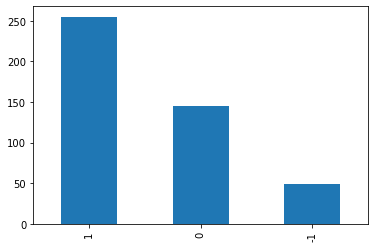

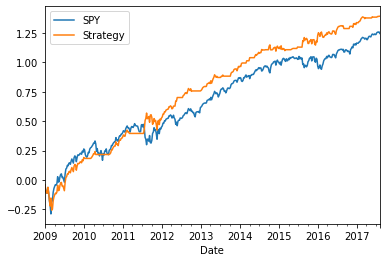

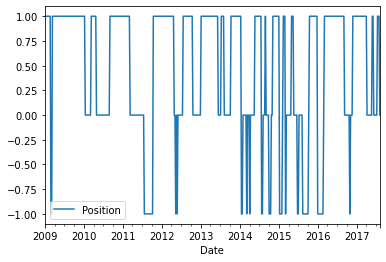

In [146]:
train = strategy(dftrain)
results(train)

The median of rolling mean of SPY returns was 0.005063564747664438
The median of rolling mean of our strategy P&L was 0.006177693342170725
The median of rolling volatilty of SPY returns was 0.024283702047572193
The median of rolling volatilty of our strategy was 0.019597723377969067

The mean of rolling mean of SPY returns was 0.004528965665058466
The mean of rolling mean of our strategy P&L was 0.005874765901367719
The mean of rolling volatilty of SPY returns was 0.028485269324625147
The mean of rolling volatilty of our strategy was 0.0250457431937465

dataset Strategy sharpe ratio (annualized): 2.913618025085844
datatset SPY sharpe ratio (annualized): 1.9769957468032002

Our positions' frequency are as follows: 
 1    77
 0    39
-1    20
Name: Position, dtype: int64

Mean returns of the long position (when it trades) are:  0.0018874030020853525
Mean returns of the short position (when it trades) are:  0.004582724161588155
Mean returns of SPY everyday is:  0.0037834438118616114




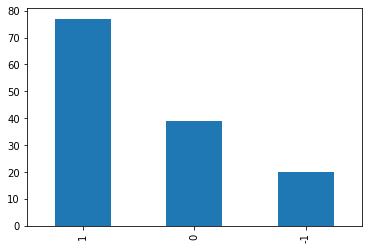

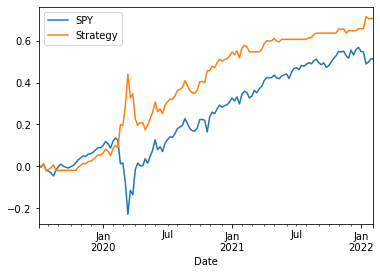

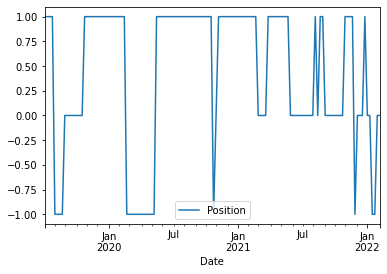

In [147]:
test = strategy(dftest)
results(test)